<h1>Data Exploration</h1>

<p>To begin, you should always take a quick look at the data and get a feel for its contents. To do so, use a Pandas DataFrame and check the shape, head and apply any necessary transformations.</p>

In [3]:
import pandas as pd
Data =pd.read_csv('fake_or_real_news.csv')
df=pd.DataFrame(Data)
df.info()
df=df.set_index('Unnamed: 0')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.0+ KB


,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


<h1>Extracting the training data</h1>

<p>Now that the DataFrame looks closer to what you need, you want to separate the labels and set up training and test datasets.

For this notebook, I decided to focus on using the longer article text. Because I knew I would be using bag-of-words and Term Frequency–Inverse Document Frequency (TF-IDF) to extract features, this seemed like a good choice. Using longer text will hopefully allow for distinct words and features for my real and fake news data.</p>

In [12]:
from sklearn.model_selection import train_test_split
y = df.label
df.drop('label',axis=1)
X_train, X_test, y_train, y_test = train_test_split(df['text'],y,test_size=0.33,random_state=53)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

4244
2091
4244
2091


<h1>Building Vectorizer Classifiers</h1>

<p>Now that you have your training and testing data, you can build your classifiers. To get a good idea if the words and tokens in the articles had a significant impact on whether the news was fake or real, you begin by using CountVectorizer and TfidfVectorizer.</p>

<p>You’ll see the example has a max threshhold set at .7 for the TF-IDF vectorizer tfidf_vectorizer using the max_df argument. This removes words which appear in more than 70% of the articles. Also, the built-in stop_words parameter will remove English stop words from the data before making vectors.</p>

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words="english")

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

count = count_vectorizer.transform(pd.Series(['Hello World','SunRise From West']))

In [15]:
print(X_train.shape)
print(count_train.toarray().shape)

len(count_vectorizer.get_feature_names())

(4244,)
(4244, 56922)


56922

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)


<p>Now that you have vectors, you can then take a look at the vector features, stored in count_vectorizer and tfidf_vectorizer.</p>

<p>Are there any noticable issues? (Yes!)</p>

<p>There are clearly comments, measurements or other nonsensical words as well as multilingual articles in the dataset that you have been using. Normally, you would want to spend more time preprocessing this and removing noise, but as this tutorial just showcases a small proof of concept, you will see if the model can overcome the noise and properly classify despite these issues.</p>

In [17]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']
['00', '000', '0000', '00000031', '000035', '00006', '0001', '0001pt', '000ft', '000km']


<h1>Intermezzo: Count versus TF-IDF Features,</h1>

<p>I was curious if my count and TF-IDF vectorizers had extracted different tokens. To take a look and compare features, you can extract the vector information back into a DataFrame to use easy Python comparisons.</p>

<p>As you can see by running the cells below, both vectorizers extracted the same tokens, but obviously have different weights. Likely, changing the max_df and min_df of the TF-IDF vectorizer could alter the result and lead to different features in each.</p>


In [18]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
difference = set(count_df.columns) - set(tfidf_df.columns)
difference

set()

In [19]:
print(count_df.equals(tfidf_df))

False


In [21]:
count_df.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
count_df.tail()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
4239,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
tfidf_df.head()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
tfidf_df.tail()

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
4239,0.0,0.014123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4240,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4241,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4242,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4243,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



<h1>Comparing Models</h1>

<p>Now it's time to train and test your models.</p>

<p>Here, you'll begin with an NLP favorite, MultinomialNB. You can use this to compare TF-IDF versus bag-of-words. My intuition was that bag-of-words (aka CountVectorizer) would perform better with this model. (For more reading on multinomial distribution and why it works best with integers, check out this fairly succinct explanation from a UPenn statistics course).</p>

<p>I personally find Confusion Matrices easier to compare and read, so I used the scikit-learn documentation to build some easily-readable confusion matrices (thanks open source!). A confusion matrix shows the proper labels on the main diagonal (top left to bottom right). The other cells show the incorrect labels, often referred to as false positives or false negatives. Depending on your problem, one of these might be more significant. For example, for the fake news problem, is it more important that we don't label real news articles as fake news? If so, we might want to eventually weight our accuracy score to better reflect this concern.</p>

<p>Other than Confusion Matrices, scikit-learn comes with many ways to visualize and compare your models. One popular way is to use a ROC Curve. There are many other ways to evaluate your model available in the scikit-learn metrics module.</p>

In [25]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
j =0
for i in y_test:
    if  i == 'FAKE':
        j+=1
        
print(j)

1008


accuracy:   0.893
Confusion matrix, without normalization


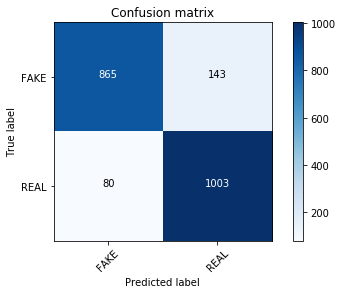

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import itertools
clf = MultinomialNB()
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

accuracy:   0.893
Confusion matrix, without normalization


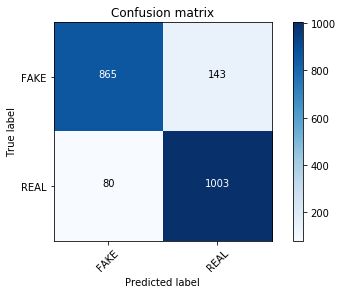

In [20]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [9]:
p = clf.predict(count)

In [10]:
p

array(['FAKE', 'FAKE'], dtype='<U4')



<p>And indeed, with absolutely no parameter tuning, your count vectorized training set count_train is visibly outperforming your TF-IDF vectors!</p>

<h1>Testing Linear Models</h1>

<p>There are a lot of great write-ups about how linear models work well with TF-IDF vectorizers (take a look at word2vec for classification, SVM reference in scikit-learn text analysis, and many more).</p>

<p>So you should use a SVM, right?</p>

<p>Well, I recently watched Victor Lavrenko's lecture on text classification and he compares Passive Aggressive classifiers to linear SVMs for text classification. We'll test this approach (which has some significant speed benefits and permanent learning disadvantages) with the fake news dataset.</p>


accuracy:   0.934
Confusion matrix, without normalization


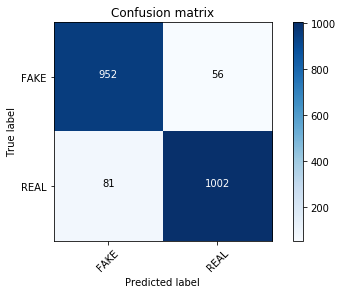

In [23]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(n_iter=50)
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<p>We can test if tuning the alpha value for a MultinomialNB creates comparable results. You can also use parameter tuning with grid search for a more exhaustive search.</p>

In [25]:
clf = MultinomialNB(alpha=0.1)
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

/usr/local/lib/python3.5/dist-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.00 Score: 0.88140
Alpha: 0.10 Score: 0.89766
Alpha: 0.20 Score: 0.89383
Alpha: 0.30 Score: 0.89000
Alpha: 0.40 Score: 0.88570
Alpha: 0.50 Score: 0.88427
Alpha: 0.60 Score: 0.87470
Alpha: 0.70 Score: 0.87040
Alpha: 0.80 Score: 0.86609
Alpha: 0.90 Score: 0.85892


<p>Not quite... At this point, it might be interesting to perform parameter tuning across all of the classifiers, or take a look at some other scikit-learn Bayesian classifiers. You could also test with a Support Vector Machine (SVM) to see if that outperforms the Passive Aggressive classifier.</p>

<p>But I am a bit more curious about what the Passive Aggressive model actually has learned. So let's move onto introspection.</p>
<h1>Introspecting models</h1>

<p>So fake news is solved, right? We achieved 93% accuracy on my dataset so let's all close up shop and go home.</p>

<p>Not quite, of course. I am wary at best of these results given how much noise we saw in the features. There is a great write-up on StackOverflow with this incredibly useful function for finding vectors that most affect labels. It only works for binary classificaiton (classifiers with 2 classes), but that's good news for you, since you only have FAKE or REAL labels.</p>

<p>Using your best performing classifier with your TF-IDF vector dataset (tfidf_vectorizer) and Passive Aggressive classifier (linear_clf), inspect the top 30 vectors for fake and real news:</p>


In [26]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)

FAKE -4.873590629600213 2016
FAKE -4.061954687865305 hillary
FAKE -3.9982536129428206 october
FAKE -3.095334814105903 share
FAKE -2.8354002818513258 november
FAKE -2.7980257553962353 article
FAKE -2.503729327716678 war
FAKE -2.4644197386182083 print
FAKE -2.3659916264943326 mosul
FAKE -2.3048031490532948 advertisement
FAKE -2.270883449132872 source
FAKE -2.26925645816088 email
FAKE -2.235962062650658 election
FAKE -2.1866838867428524 oct
FAKE -1.9330529208864276 donald
FAKE -1.914615888921031 nov
FAKE -1.8602591527284755 podesta
FAKE -1.8165831186599846 photo
FAKE -1.8142665492319918 establishment
FAKE -1.7779977679915169 corporate
FAKE -1.756518794204212 entire
FAKE -1.7476260662543652 wikileaks
FAKE -1.7237704753503185 snip
FAKE -1.7114836183822297 brexit
FAKE -1.6409508202799303 ayotte
FAKE -1.612802357794712 reuters
FAKE -1.6074314981529247 elect
FAKE -1.5788304434201321 26
FAKE -1.5782985264261384 jewish
FAKE -1.5573209204168985 mainstream

REAL 4.7470791436887305 said
REAL 2.8074

<h1>Intermezzo: HashingVectorizer</h1>

<p>Another vectorizer used sometimes for text classification is a HashingVectorizer. HashingVectorizers require less memory and are faster (because they are sparse and use hashes rather than tokens) but are more difficult to introspect. You can read a bit more about the pros and cons of using HashingVectorizer in the scikit-learn documentation if you are interested.</p>

<p>You can give it a try and compare its results versus the other vectorizers. It performs fairly well, with better results than the TF-IDF vectorizer using MultinomialNB (this is somewhat expected due to the same reasons CountVectorizers perform better), but not as well as the TF-IDF vectorizer with Passive Aggressive linear algorithm.</p>

accuracy:   0.902
Confusion matrix, without normalization


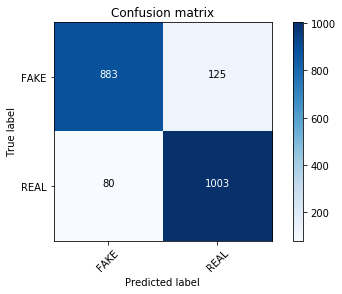

In [27]:
from sklearn.feature_extraction.text import HashingVectorizer
hash_vectorizer = HashingVectorizer(stop_words='english', non_negative=True)
hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)
clf = MultinomialNB(alpha=.01)
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h1>Conclusion</h1>
<p>But you did get to play around with a new dataset, test out some NLP classification models and introspect how successful they were? Yes.</p>

<p>As expected from the outset, defining fake news with simple bag-of-words or TF-IDF vectors is an oversimplified approach. Especially with a multilingual dataset full of noisy tokens. If you hadn't taken a look at what your model had actually learned, you might have thought the model learned something meaningful. So, remember: always introspect your models (as best you can!).</p>
